# Data Prep

## Import Libraries


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm
from lightgbm import LGBMClassifier


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from scipy import stats



RSEED=42

pd.set_option('display.float_format', lambda x: '%.5f' % x)

import warnings
warnings.simplefilter('ignore')

N_JOBS= 8
RSEED = 12345
PRIMARY_SCORE = "f1"
COUNTER_TYPE_MAPPING = {"ELEC": 0, "GAZ": 1}
MAX_FEATURES_PER_ROW = 6
TARGET_LABELS = {0: "Regular", 1: "Fraud"}
COLUMNS_ONE_HOT_ENCODING = [
    "disrict", 
    "region", 
    "client_catg", 
    "tarif_type", 
    "reading_remarque",
	"counter_type", 
    "counter_code", 
    "counter_statue", 
    "counter_coefficient"
]

In [3]:
def print_data(df):
    print(df.shape[0], df[df.target == 1].shape[0], df.client_id.nunique(), df.loc[df.target ==1, 'client_id'].nunique())

def feature_count(col_list,df,targ=[1]):
    all_unique_shape = df['client_id'].nunique()
    print_data(df)
    for feature in col_list:
        f_unique = df[feature].unique()
        str = ''
        for i in f_unique:
            target_unique_shape = df.loc[(df[feature]==i)&(df.target.isin(targ)),'client_id'].nunique()

            if round(target_unique_shape/all_unique_shape*100) > 0:
                target_shape = df[(df[feature]==i)&(df.target.isin(targ))].shape[0]           
                all_shape = df[df[feature]==i].shape[0]
                str += f'{i} ({target_unique_shape} {round(target_unique_shape/all_unique_shape*100)}% /{round(target_shape/all_shape*100)}%: {target_shape}/{all_shape}), '

        print(feature,str)

def aggregate_by_client_id(invoice_data):
    aggs = {}
    #aggs['cons_l1_month'] = ['max']
    # aggs['cons_l2_month'] = ['max']
    # aggs['cons_l3_month'] = ['max']
    # aggs['cons_l4_month'] = ['max']
    #aggs['invoice_date'] = ['min','max']
    #aggs['months_number'] = ['sum']
    aggs['consumption'] = ['sum']
    

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='transactions_count'))
    

    return pd.merge(df, agg_trans, on='client_id', how='left')


def histplot_target(train,num_cols,nrows,ncolumns):

    fig, ax = plt.subplots(nrows, ncolumns,figsize=(18,18))
    ax = ax.ravel()

    for i in range(len(num_cols)):
        print(num_cols[i])
        ax[i].set_title('Histogram: ' + num_cols[i])
        ax[i].hist(train.loc[train.target == 0, num_cols[i]])
        ax[i].hist(train.loc[train.target == 1, num_cols[i]])
    
    plt.show()

## Read the Data

In [4]:
client_train = pd.read_csv('data/train/client_train.csv', low_memory=False)
invoice_train = pd.read_csv('data/train/invoice_train.csv', low_memory=False)

client_test = pd.read_csv('data/test/client_test.csv', low_memory=False)
invoice_test = pd.read_csv('data/test/invoice_test.csv', low_memory=False)
sample_submission = pd.read_csv('data/SampleSubmission.csv', low_memory=False)

## Data Understanding

In [5]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_train.shape)

(135493, 6) (4476749, 16) (58069, 5) (4476749, 16)


In [6]:
#print top rows of dataset
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [7]:
#print top rows of dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.00000
1,69,train_Client_1,11,107,29/05/2002,0.00000
2,62,train_Client_10,11,301,13/03/1986,0.00000
3,69,train_Client_100,11,105,11/07/1996,0.00000
4,62,train_Client_1000,11,303,14/10/2014,0.00000


In [8]:
#Get a summary for all numerical columns
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4476749.00000,4476749.00000,4476749.00000,4476749.00000,4476749.00000,4476749.00000,4476749.00000,4476749.00000,4476749.00000,4476749.00000,4476749.00000,4476749.00000
mean,20.12804,123058699065.18332,172.48843,7.32170,1.00304,410.97950,109.32248,20.30620,52.92588,17766.99826,18349.70462,44.83095
std,13.47256,1657267274261.92676,133.88710,1.57165,0.30835,757.30800,1220.12334,157.42394,875.47248,40366.92561,40953.20625,3128.33539
min,8.00000,0.00000,0.00000,5.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,11.00000,121108.00000,5.00000,6.00000,1.00000,79.00000,0.00000,0.00000,0.00000,1791.00000,2056.00000,4.00000
50%,11.00000,494561.00000,203.00000,8.00000,1.00000,274.00000,0.00000,0.00000,0.00000,7690.00000,8192.00000,4.00000
75%,40.00000,1115161.00000,207.00000,9.00000,1.00000,600.00000,0.00000,0.00000,0.00000,21660.00000,22343.00000,4.00000
max,45.00000,27981145458733.00000,600.00000,413.00000,50.00000,999910.00000,999073.00000,64492.00000,547946.00000,2800280.00000,2870972.00000,636624.00000


In [9]:
#Get a summary for all numerical columns
client_train.describe()

,disrict,client_catg,region,target
count,135493.00000,135493.00000,135493.00000,135493.00000
mean,63.51122,11.51251,206.15981,0.05584
std,3.35440,4.42376,104.20704,0.22961
min,60.00000,11.00000,101.00000,0.00000
25%,62.00000,11.00000,103.00000,0.00000
50%,62.00000,11.00000,107.00000,0.00000
75%,69.00000,11.00000,307.00000,0.00000
max,69.00000,51.00000,399.00000,1.00000


In [10]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [11]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [12]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [13]:
#Getting unique values on the invoice train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [14]:
#check for missing values
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [15]:
#check for missing values
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

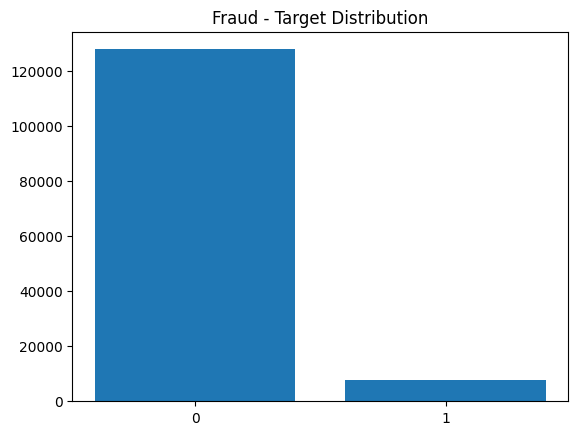

In [16]:
#Visualize fraudulent activities
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

In [17]:
client_train[client_train.target == 1].shape[0]

7566

In [18]:
client_train[client_train.target == 1].shape[0]/client_train.shape[0]

0.05584052312665599

## Data Cleaning and Engineering

In [19]:
client_train['creation_date'] = pd.to_datetime(client_train["creation_date"])
invoice_train['invoice_date'] = pd.to_datetime(invoice_train["invoice_date"])

In [20]:
df = invoice_train.merge(client_train, on="client_id")
# df['creation_date'] = pd.to_datetime(df["creation_date"], format="%d/%m/%Y")
# df['invoice_date'] = pd.to_datetime(df["invoice_date"], format="%Y-%m-%d")

df["target"] = df["target"].astype(int)
df["counter_type"] = df["counter_type"].map(COUNTER_TYPE_MAPPING).astype(int)
df["counter_statue"] = df["counter_statue"].replace("A", 10).astype(int)
df["invoice_month"] = df.invoice_date.dt.month
df["consumption"] = df.consommation_level_1 + df.consommation_level_2 + df.consommation_level_3 + df.consommation_level_4
df['tarif'] = np.where(df.consommation_level_2 == 0, 3, np.where(df.consommation_level_1/df.months_number == 200,1,np.where(df.consommation_level_1/df.months_number == 300,2,3)))
df['cons_l1_month'] = df.consommation_level_1/df.months_number
df['cons_l2_month'] = df.consommation_level_2/df.months_number
df['cons_l3_month'] = df.consommation_level_3/df.months_number
df['cons_l4_month'] = df.consommation_level_4/df.months_number

#df["invoice_date"] = invoice_date.dt.strftime("%Y%m%d").astype(int)
#df["invoice_year"] = invoice_date.dt.year

#df["invoice_month_ts"] = invoice_date.dt.strftime("%Y%m").astype(int)

#df["creation_date"] = creation_date.dt.strftime("%Y%m%d").astype(int)
#df["creation_year"] = creation_date.dt.year
#df["creation_month"] = creation_date.dt.month
print_data(df)

4476749 353112 135493 7566


In [21]:
df = df[(df.months_number>0)\
            &(df.months_number<100)\
            & (df.counter_statue <= 5)\
            &(df.invoice_date.dt.year >= 2005)\
            &(df.counter_type == 0)\
            &(df.consumption > 0)\
            &((df.new_index-df.old_index)>=0)\
            &(df.new_index - df.old_index == df.consumption)]

#df = df.drop(['old_index','new_index'],axis=1)

print_data(df)


2822507 215793 124900 7528


In [22]:
df.columns

Index(['client_id', 'invoice_date', 'tarif_type', 'counter_number',
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index', 'months_number', 'counter_type', 'disrict', 'client_catg',
       'region', 'creation_date', 'target', 'invoice_month', 'consumption',
       'tarif', 'cons_l1_month', 'cons_l2_month', 'cons_l3_month',
       'cons_l4_month'],
      dtype='object')

In [23]:
range(1,13)

range(1, 13)

In [24]:
pivot_df = df.pivot_table(index = 'client_id',columns='invoice_month',values= 'consumption',aggfunc='sum' ).reset_index()
pivot_df = pivot_df.fillna(0)

In [25]:
pivot_df

invoice_month,client_id,1,2,3,4,5,6,7,8,9,10,11,12
0,train_Client_0,592.00000,361.00000,3239.00000,0.00000,0.00000,402.00000,3437.00000,0.00000,0.00000,559.00000,3573.00000,541.00000
1,train_Client_1,2451.00000,2196.00000,2315.00000,2139.00000,3740.00000,1029.00000,931.00000,0.00000,3404.00000,2424.00000,0.00000,0.00000
2,train_Client_10,0.00000,1737.00000,815.00000,0.00000,4581.00000,2761.00000,0.00000,0.00000,0.00000,4287.00000,876.00000,0.00000
3,train_Client_100,0.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,16.00000,0.00000,0.00000,0.00000
4,train_Client_1000,0.00000,1241.00000,0.00000,736.00000,0.00000,1932.00000,0.00000,1908.00000,1695.00000,0.00000,2506.00000,2899.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124895,train_Client_99993,2065.00000,764.00000,1460.00000,1807.00000,661.00000,1834.00000,2677.00000,2512.00000,1409.00000,930.00000,277.00000,696.00000
124896,train_Client_99994,0.00000,0.00000,0.00000,37.00000,0.00000,0.00000,0.00000,9.00000,0.00000,0.00000,0.00000,0.00000
124897,train_Client_99996,0.00000,2009.00000,0.00000,0.00000,0.00000,881.00000,0.00000,0.00000,342.00000,2993.00000,0.00000,0.00000
124898,train_Client_99997,0.00000,1771.00000,372.00000,0.00000,516.00000,1056.00000,1473.00000,613.00000,441.00000,348.00000,1671.00000,649.00000


In [26]:
#group invoice data by client_id
df_agg = aggregate_by_client_id(df)
df_agg = pd.merge(df_agg,client_train[['client_id','target']],on='client_id')
df_agg2 = df.groupby('client_id')['tarif'].agg(lambda x: x.mode().max())
df_agg = pd.merge(df_agg,df_agg2,on='client_id')
df_agg = pd.merge(df_agg,pivot_df,on='client_id')


In [27]:
df_agg = df_agg.drop('consumption_sum',axis=1)

In [28]:
df_agg

,client_id,transactions_count,target,tarif,1,2,3,4,5,6,7,8,9,10,11,12
0,train_Client_0,35,0.00000,3,592.00000,361.00000,3239.00000,0.00000,0.00000,402.00000,3437.00000,0.00000,0.00000,559.00000,3573.00000,541.00000
1,train_Client_1,37,0.00000,3,2451.00000,2196.00000,2315.00000,2139.00000,3740.00000,1029.00000,931.00000,0.00000,3404.00000,2424.00000,0.00000,0.00000
2,train_Client_10,18,0.00000,3,0.00000,1737.00000,815.00000,0.00000,4581.00000,2761.00000,0.00000,0.00000,0.00000,4287.00000,876.00000,0.00000
3,train_Client_100,4,0.00000,3,0.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,16.00000,0.00000,0.00000,0.00000
4,train_Client_1000,14,0.00000,3,0.00000,1241.00000,0.00000,736.00000,0.00000,1932.00000,0.00000,1908.00000,1695.00000,0.00000,2506.00000,2899.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124895,train_Client_99993,25,0.00000,3,2065.00000,764.00000,1460.00000,1807.00000,661.00000,1834.00000,2677.00000,2512.00000,1409.00000,930.00000,277.00000,696.00000
124896,train_Client_99994,3,0.00000,3,0.00000,0.00000,0.00000,37.00000,0.00000,0.00000,0.00000,9.00000,0.00000,0.00000,0.00000,0.00000
124897,train_Client_99996,20,0.00000,3,0.00000,2009.00000,0.00000,0.00000,0.00000,881.00000,0.00000,0.00000,342.00000,2993.00000,0.00000,0.00000
124898,train_Client_99997,22,0.00000,3,0.00000,1771.00000,372.00000,0.00000,516.00000,1056.00000,1473.00000,613.00000,441.00000,348.00000,1671.00000,649.00000


In [30]:
train = df[['counter_statue', 'counter_code', 'reading_remarque','months_number', 'counter_type', 'disrict', 'client_catg',
       'region', 'invoice_month', 'consumption',
       'tarif', 'cons_l1_month', 'cons_l2_month', 'cons_l3_month',
       'cons_l4_month','target']]


In [33]:
train_agg = df_agg.drop(['client_id','tarif'],axis=1)
train_agg.columns = ['transactions_count', 'target', 'm1','m2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']

counter_statue
counter_code
reading_remarque
months_number
disrict
client_catg
region
invoice_month
consumption
tarif
cons_l1_month
cons_l2_month
cons_l3_month
cons_l4_month
target


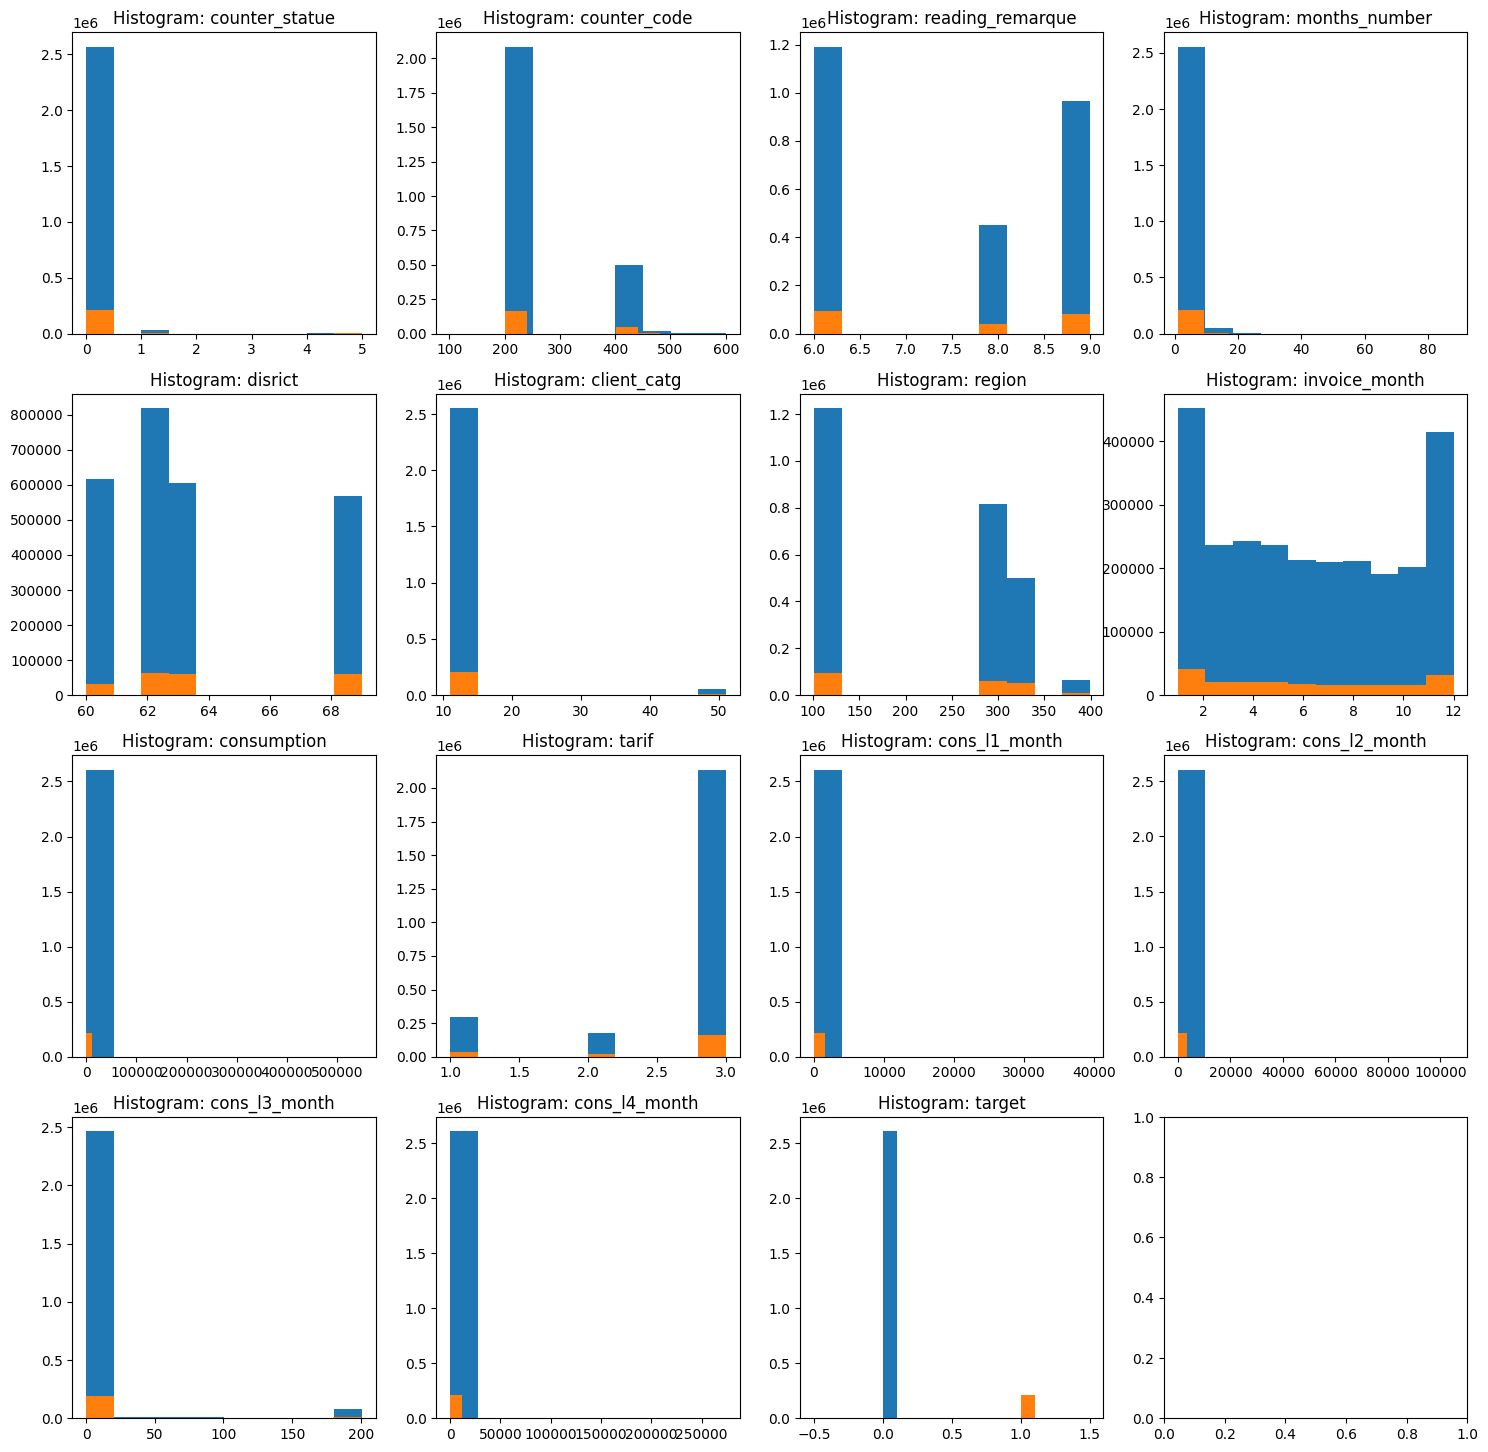

In [32]:
#num_cols = ['transactions_count',  'm1','m2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']
num_cols = ['counter_statue', 'counter_code', 'reading_remarque', 'months_number', 'disrict',\
             'client_catg', 'region', 'invoice_month', 
       'consumption', 'tarif', 'cons_l1_month', 'cons_l2_month',
       'cons_l3_month', 'cons_l4_month', 'target']
def histplot_target(train,num_cols,nrows,ncolumns):

    fig, ax = plt.subplots(nrows, ncolumns,figsize=(18,18))
    ax = ax.ravel()

    for i in range(len(num_cols)):
        print(num_cols[i])
        ax[i].set_title('Histogram: ' + num_cols[i])
        ax[i].hist(train.loc[train.target == 0, num_cols[i]])
        ax[i].hist(train.loc[train.target == 1, num_cols[i]])
    
    plt.show()

histplot_target(train,num_cols,4,4)

# Modelling

In [46]:
X = train.drop(columns=['target'])
y = train['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)

## Stacking

In [36]:
# Implementation of Stacking in Scikit-Learn
from sklearn.ensemble import StackingClassifier

estimators = [
    ('dt', DecisionTreeClassifier(random_state = RSEED)),
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(random_state = RSEED))
]

clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression())
clf.fit(X_train, y_train).score(X_test, y_test)

0.92354600943558

In [39]:
preds = clf.predict(X_test)
preds = pd.DataFrame(preds, columns=['target'])
cm = confusion_matrix(y_test, preds)
cm

array([[651679,      0],
       [ 53948,      0]])

## Train LGBM *Classifier*

In [49]:
model = LGBMClassifier(boosting_type='gbdt', num_iterations=500)
model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 161845, number of negative: 1955035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1391
[LightGBM] [Info] Number of data points in the train set: 2116880, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076454 -> initscore=-2.491524
[LightGBM] [Info] Start training from score -2.491524


LGBMClassifier(num_iterations=500)

## Make Predictions on test set

In [50]:
preds = model.predict(X_test)
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

,target
0,0
1,0
2,0
3,0
4,0


In [51]:
cm = confusion_matrix(y_test, preds)
cm

array([[651327,    352],
       [ 52853,   1095]])

In [52]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


RandomForestClassifier(n_jobs=-1, random_state=12345, verbose=1)

In [53]:
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.9s finished


array([[636575,  15104],
       [ 50082,   3866]])

## Class Weight

In [54]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
model = RandomForestClassifier(class_weight=dict(enumerate(class_weights)),n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.3s finished


RandomForestClassifier(class_weight={0: 0.541391767566369,
                                     1: 6.539848373209511},
                       n_jobs=-1, random_state=12345, verbose=1)

In [55]:
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.6s finished


array([[598505,  53174],
       [ 46583,   7365]])

### RandomOverSampler

In [56]:
#!pip install imblearn

In [57]:
from imblearn.over_sampling import RandomOverSampler

#RandomOverSampler
ros = RandomOverSampler()

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_resampled.shape, y_resampled.shape)

(2116880, 15) (2116880,) (3910070, 15) (3910070,)


In [58]:
#X_train,X_test,y_train,y_test = train_test_split(X_resampled, y_resampled,stratify=y_resampled)
model = LGBMClassifier(boosting_type='gbdt', num_iterations=500)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 161845, number of negative: 1955035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1391
[LightGBM] [Info] Number of data points in the train set: 2116880, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076454 -> initscore=-2.491524
[LightGBM] [Info] Start training from score -2.491524


LGBMClassifier(num_iterations=500)

In [59]:
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

array([[651327,    352],
       [ 52853,   1095]])

In [60]:
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   58.7s finished


RandomForestClassifier(n_jobs=-1, random_state=12345, verbose=1)

In [61]:
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.9s finished


array([[636574,  15105],
       [ 50082,   3866]])

In [62]:
from imblearn.over_sampling import SMOTE

# SMOTE
smote = SMOTE()

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_resampled.shape, y_resampled.shape)

(2116880, 15) (2116880,) (3910070, 15) (3910070,)


In [63]:
#X_train,X_test,y_train,y_test = train_test_split(X_resampled, y_resampled,stratify=y_resampled)
model = LGBMClassifier(boosting_type='gbdt', num_iterations=500)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 161845, number of negative: 1955035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1391
[LightGBM] [Info] Number of data points in the train set: 2116880, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076454 -> initscore=-2.491524
[LightGBM] [Info] Start training from score -2.491524


LGBMClassifier(num_iterations=500)

In [64]:
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

array([[651327,    352],
       [ 52853,   1095]])

In [65]:
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


RandomForestClassifier(n_jobs=-1, random_state=12345, verbose=1)

In [66]:
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.4s finished


array([[636574,  15105],
       [ 50082,   3866]])

In [67]:
from imblearn.over_sampling import ADASYN

# ADASYN
adasyn = ADASYN()

X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

In [68]:
#X_train,X_test,y_train,y_test = train_test_split(X_resampled, y_resampled,stratify=y_resampled)
model = LGBMClassifier(boosting_type='gbdt', num_iterations=500)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 161845, number of negative: 1955035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1391
[LightGBM] [Info] Number of data points in the train set: 2116880, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076454 -> initscore=-2.491524
[LightGBM] [Info] Start training from score -2.491524


LGBMClassifier(num_iterations=500)

In [69]:
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

array([[651327,    352],
       [ 52853,   1095]])

In [70]:
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   58.5s finished


RandomForestClassifier(n_jobs=-1, random_state=12345, verbose=1)

In [71]:
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.8s finished


array([[636574,  15105],
       [ 50082,   3866]])

## Aggrigated table

In [72]:
X = train_agg.drop(columns=['target'])
y = train_agg['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)

In [73]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished


RandomForestClassifier(n_jobs=-1, random_state=12345, verbose=1)

In [74]:
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


array([[29334,     9],
       [ 1879,     3]])